In [277]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
from xgboost import plot_importance

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split ,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score ,recall_score ,precision_score ,accuracy_score\
,confusion_matrix ,ConfusionMatrixDisplay

from xgboost import XGBClassifier

import pickle

In [291]:
def conf_matrix_plot(model,model_name, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot()
    plt.title(model_name)
    plt.show()

In [139]:
def make_model_results(model_name, model_object):
    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = table.append({'Model': model_name,
                        'F1': f1,
                        'Recall': recall,
                        'Precision': precision,
                        'Accuracy': accuracy
                        },
                        ignore_index=True
                       )
  
    return table

In [140]:
def prediction_result(y_test):
    for i in y_test:
        if i != 'Exited':
            print(i)
            print('Accuracy:', '%.3f' % accuracy_score(y_test['Exited'], y_test[i]))
            print('Precision:', '%.3f' % precision_score(y_test['Exited'], y_test[i]))
            print('Recall:', '%.3f' % recall_score(y_test['Exited'], y_test[i]))
            print('F1 Score:', '%.3f' % f1_score(y_test['Exited'], y_test[i]))
            print("")

In [141]:
#Read in data
df_original = pd.read_csv('Data\churn.csv')
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [142]:
#Explore data
df_original.info()
df_original.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [143]:
#Check class balance
df_original['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [144]:
#Select column
df = df_original.drop(['RowNumber','CustomerId','Surname','Gender'],axis = 1)
df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


In [145]:
#Endcoding
df = pd.get_dummies(df,drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1


In [236]:
# Define the x(predictor), y(target) variable
x = df.drop('Exited',axis= 1)
y = df['Exited']
#Split data
x_train ,x_test ,y_train ,y_test = train_test_split(x ,y ,test_size = 0.25 ,stratify = y ,random_state = 0)
y_test = pd.DataFrame(y_test)
#scaling data
scaler = MinMaxScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# modeling

In [237]:
#Naive Bayes
gnb = GaussianNB()

#Decision Tree
tree = DecisionTreeClassifier(random_state=0)

#Random Forest(tree base + bagging)
rf = RandomForestClassifier(random_state=0)

#Extreme gradient boosting(tree base + boosting)
xgb = XGBClassifier(objective='binary:logistic', random_state=0)


In [238]:
#Fit the model
gnb.fit(x_train_scaled,y_train)
tree.fit(x_train,y_train)
rf.fit(x_train,y_train)
xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [239]:
#Get prediction on test data
y_test['naive bayes'] = gnb.predict(x_test_scaled)
y_test['decision tree'] = tree.predict(x_test)
y_test['random forest'] = rf.predict(x_test)
y_test['xgbooster'] = xgb.predict(x_test)

In [240]:
prediction_result(y_test)

naive bayes
Accuracy: 0.827
Precision: 0.643
Recall: 0.336
F1 Score: 0.441

decision tree
Accuracy: 0.795
Precision: 0.497
Recall: 0.528
F1 Score: 0.512

random forest
Accuracy: 0.864
Precision: 0.766
Recall: 0.475
F1 Score: 0.587

xgbooster
Accuracy: 0.850
Precision: 0.704
Recall: 0.458
F1 Score: 0.555



In [241]:
result = pd.DataFrame()
for i in y_test:
        if i != 'Exited':
             result = result.append({'Model': i,
                        'F1': f1_score(y_test['Exited'],y_test[i]),
                        'Recall': recall_score(y_test['Exited'], y_test[i]),
                        'Precision': precision_score(y_test['Exited'], y_test[i]),
                        'Accuracy': accuracy_score(y_test['Exited'], y_test[i])
                        },
                        ignore_index=True
                                   )
          

In [242]:
result

,Model,F1,Recall,Precision,Accuracy
0,naive bayes,0.441290,0.335953,0.642857,0.8268
1,decision tree,0.512381,0.528487,0.497227,0.7952
2,random forest,0.586667,0.475442,0.765823,0.8636
3,xgbooster,0.554762,0.457760,0.703927,0.8504


# Cross-validated hyperparameter tuning

In [155]:
scoring = {'accuracy','precision','recall','f1'}

#Decision Tree
tuned_tree = DecisionTreeClassifier(random_state=0)
tree_param = {'max_depth': [5,10,15,20,30,40,50,None],
              'min_samples_leaf' : [2,5,10,15],
              'min_samples_split' : [2,5,10,15]}
tuned_tree_cv = GridSearchCV(tuned_tree ,tree_param ,scoring=scoring ,cv=5 ,refit='f1')

#Random Forest(tree base + bagging)
tuned_rf = RandomForestClassifier(random_state=0)
rf_param = {'max_depth': [5,10,15,20,30,40,50,None],
            'min_samples_leaf' : [2,5,10,15],
            'min_samples_split' : [2,5,10,15],
            'max_features' : [2,3,4,5],
            'n_estimators' : [75,100,125,150]}
tuned_rf_cv = GridSearchCV(tuned_rf, rf_param ,scoring=scoring ,cv=5 ,refit='f1')

#Extreme gradient boosting(tree base + boosting)
tuned_xgb = XGBClassifier(objective='binary:logistic', random_state=0)
xgb_param = {'max_depth' : [5,10,15,20,None],
             'min_child_weight' : [2,5,10,15],
             'n_estimators' : [75,100,125,150],
             'learning_rate' : [0.05,0.1,0.2,0.3]}
tuned_xgb_cv = GridSearchCV( tuned_xgb ,xgb_param ,scoring=scoring ,refit='f1')

In [157]:
#fit the model
%%time
tuned_tree_cv.fit(x_train,y_train)
tuned_rf_cv.fit(x_train,y_train)
tuned_xgb_cv.fit(x_train,y_train)

Wall time: 1h 33min 5s


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     n

In [174]:
#Pickle the model

with open('tree_cv_model.pickle', 'wb') as to_write:
    pickle.dump(tuned_tree_cv, to_write) 

with open('rf_cv_model.pickle', 'wb') as to_write:
    pickle.dump(tuned_rf_cv, to_write) 

with open('xgb_cv_model.pickle', 'wb') as to_write:
    pickle.dump(tuned_xgb_cv, to_write) 

In [183]:
# Read in pickled model

with open('tree_cv_model.pickle', 'rb') as to_read:
    tree_cv = pickle.load(to_read) 

with open('rf_cv_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read) 

with open('xgb_cv_model.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read) 


In [243]:
print(tree_cv.best_params_)
print(rf_cv.best_params_)
print(xgb_cv.best_params_)

{'max_depth': 5, 'min_samples_leaf': 15, 'min_samples_split': 2}
{'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 75}
{'learning_rate': 0.1, 'max_depth': None, 'min_child_weight': 5, 'n_estimators': 100}


In [244]:
result = pd.concat([make_model_results('decision tree cv',tree_cv),result])

In [245]:
result = pd.concat([make_model_results('random forest cv',rf_cv),result])

In [246]:
result = pd.concat([make_model_results('xgbooster cv',xgb_cv),result])

In [247]:
result.sort_values(by='F1',ascending=False)

,Model,F1,Recall,Precision,Accuracy
0,random forest cv,0.599749,0.492159,0.769045,0.866267
0,xgbooster cv,0.599723,0.497379,0.755904,0.864800
2,random forest,0.586667,0.475442,0.765823,0.863600
0,decision tree cv,0.582266,0.488852,0.723527,0.857467
3,xgbooster,0.554762,0.457760,0.703927,0.850400
1,decision tree,0.512381,0.528487,0.497227,0.795200
0,naive bayes,0.441290,0.335953,0.642857,0.826800


In [248]:
y_test['decision tree cv'] = tree_cv.predict(x_test)
y_test['random forest cv'] = rf_cv.predict(x_test)
y_test['xgbooster cv'] = xgb_cv.predict(x_test)

In [295]:
all_model = [gnb,tree,rf,xgb,tree_cv,rf_cv,xgb_cv]
model = ['naivebayes','decisiontree','randomforest','xgbooster','tuned decition tree','tuned randomforest','tuned xgbooster']

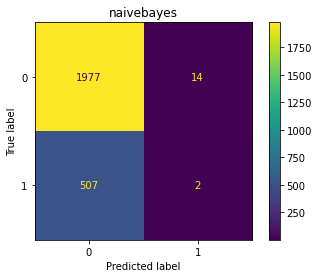

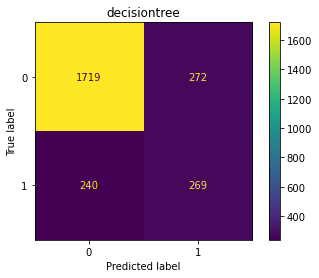

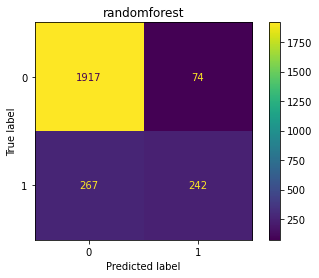

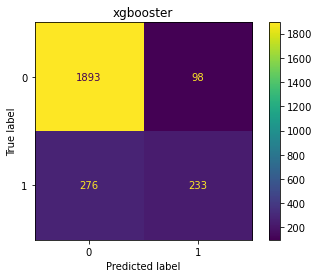

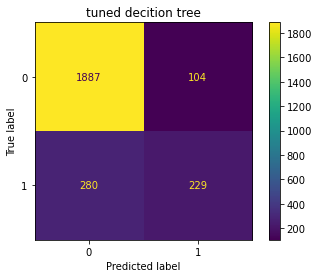

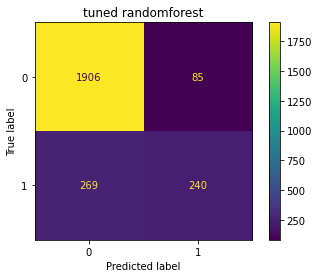

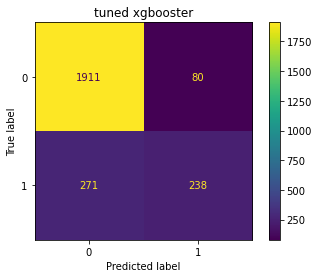

In [296]:
for i,n in zip(all_model,model):
    conf_matrix_plot(i,n,x_test,y_test['Exited'])

In [249]:
prediction_result(y_test)

naive bayes
Accuracy: 0.827
Precision: 0.643
Recall: 0.336
F1 Score: 0.441

decision tree
Accuracy: 0.795
Precision: 0.497
Recall: 0.528
F1 Score: 0.512

random forest
Accuracy: 0.864
Precision: 0.766
Recall: 0.475
F1 Score: 0.587

xgbooster
Accuracy: 0.850
Precision: 0.704
Recall: 0.458
F1 Score: 0.555

decision tree cv
Accuracy: 0.846
Precision: 0.688
Recall: 0.450
F1 Score: 0.544

random forest cv
Accuracy: 0.858
Precision: 0.738
Recall: 0.472
F1 Score: 0.576

xgbooster cv
Accuracy: 0.860
Precision: 0.748
Recall: 0.468
F1 Score: 0.576



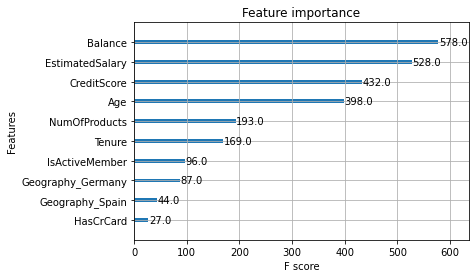

In [268]:
plot_importance(xgb_cv.best_estimator_);